In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dataset_utils
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import torch.nn as nn
from torch.utils.data import DataLoader
import itertools
from collections import defaultdict
from Utils import MAPE, RMSELoss, EarlyStopper
import pickle
from Utils import global_seed, MyTimeSeriesSplitter, TestFixedSplitter, write_table
import gan_model
from train import cGAN_fitter

/home/grinenko/anaconda3/envs/anna/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
soft = ['35_21_1000.Q.KatKlD.1444.octanI', 
        '35_21_1000.Q.KatKlAB.DavNpar', 
        '35_21_1000.Q.KatKlAB.EBen70', 
        '35_21_1000.Q.KatKlAB.AroPf.v']

**Параметры**

In [4]:
K = 60 #усреднение
SOFT_SENSOR_INDEX = 2
W=5
SOFT_SENSOR_NAME = soft[SOFT_SENSOR_INDEX]
PERIODS_FILE = "periods_W20_gr{}_Agl.npy".format(K)
SEED = 42    

In [5]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda', 3)

print(type(device), device)

<class 'torch.device'> cuda:3


**Загрузка датасета и подготовка данных**

In [6]:
data = pd.read_csv("Dataset1_nans.csv", sep=";")
soft_data = data[soft].copy()
data_orig = data.drop(soft + ['Timestamp'], axis=1)
del data

In [7]:
soft_data.mean()

35_21_1000.Q.KatKlD.1444.octanI    99.461166
35_21_1000.Q.KatKlAB.DavNpar       46.135991
35_21_1000.Q.KatKlAB.EBen70         4.792103
35_21_1000.Q.KatKlAB.AroPf.v       67.622938
dtype: float64

In [8]:
dataset = dataset_utils.Dataset(data_orig, soft_data[SOFT_SENSOR_NAME], K=K, diff=False, periods=PERIODS_FILE)
dataset_x, dataset_y, y_scaler = dataset.window_view(W=W, scale_target=True)


window_view: (1035, 5, 57) (1035,)


In [9]:
y_scaler.mean, dataset_y.mean()

(4.574975845410628, 5.4921177643292767e-17)

**Вспомогательные функции**

In [10]:
# Визуализация процесса обучения
# метрики на обучающей и валидационной выборках для генератора, дискриминатора и регрессора

def visualize_plot(dictionary, title=None, log=False):
    if log:
        plt.yscale('log')
    for label, elem in dictionary.items():
        plt.plot(elem, label=label)
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.show()

def visualize_subplots(dictionary, log=False, clip_first=0, dilation=0):
    n = len(dictionary)
    # plt.rcParams["figure.figsize"] = (20,3)
#     f.set_figheight(15)
# f.set_figwidth(15)
    plt.figure(figsize=(16, 7))
    for i, (key, value) in enumerate(dictionary.items()):
        plt.subplot(1, n, i+1)
        for label, elem in value.items():
            len_x = len(elem)
            x = np.arange(len_x)
            x = x[int(len_x * clip_first):]
            elem = elem[int(len_x * clip_first):]
            if dilation > 0:
                tmp_len = int(dilation * len_x)
                elem = np.array(elem[:len(elem) - len(elem) % tmp_len]).reshape(-1, tmp_len).mean(axis=1)
                x = np.array(x[:len(x) - len(x) % tmp_len]).reshape(-1, tmp_len).mean(axis=1)
#                 elem = elem[::int(dilation * len_x)]
#                 x = x[::int(dilation * len_x)]
            plt.plot(x, elem, label=label)
        if log:
            plt.yscale('symlog')
        plt.title(key)
        plt.legend()
    
    plt.plot()

In [11]:
def save_models(D=None, G=None, R=None, path=""):
    if not isinstance(D, list):
        D, G, R = [D], [G], [R]
    for i, (dis, gen, reg) in enumerate(zip(D, G, R)):
        torch.save(dis.state_dict(), f"{path}_D_{i}.pth")    
        torch.save(gen.state_dict(), f"{path}_G_{i}.pth")
        torch.save(reg.state_dict(), f"{path}_R_{i}.pth")    

**Обучение моделей**

In [12]:
def trainCV(X, y, D_class=None, G_class=None, R_class=None, G_params=dict(), R_params=dict(), D_params=dict(),\
            n_folds=5, seed=42, train_size_in_folds=3, tables_path=None, splitter=MyTimeSeriesSplitter(), y_scaler=None, **kwargs):
    """
    Cross-validation with gived schema.
    
    Args:
        X (np.array or torch.tensor) : x data
        y (np.array or torch.tensor) : target data
        D_class : Discriminator class
        G_class : Generator class
        R_class : Regressor class
        G_params (dict) : parameters for instantiation Generator
        R_params (dict) : parameters for instantiation Regressor
        D_params (dict) : parameters for instantiation Discriminator
        n_folds (int) : number of folds
        seed (int) : random seed
        train_size_in_folds (int) : minimum number of folds in train
        tables_path (string) : where to save results table in each step of cross-validation
        splitter : object of Splitter class, schema to organize cross-validation
        
    Returns:
        losses (List[dict]) : list of losses for each step (for each model and train-valid-test mode)
        Ds : list of trained Discriminator model
        Gs : list of trained Generator model
        Rs : list of trained Regressor model
        results (List[pd.DataFrame]) : if tables_path is None, results from each step
    """
    X, y = [torch.tensor(tmp, dtype=torch.float32) for tmp in (X, y)]
    losses, Ds, Gs, Rs = [], [], [], []
    results = []
    fitter = cGAN_fitter(y_scaler=y_scaler, **kwargs)
    for i, (train_inds, test_inds) in enumerate(splitter.split(X)):
        print("______________")
        global_seed(seed)
        D = D_class(**D_params) 
        G = G_class(**G_params) 
        R = R_class(**R_params) 
        train_x, train_y, test_x, test_y = X[train_inds], y[train_inds], X[test_inds], y[test_inds]
        train_inds, valid_inds = train_test_split(train_inds, test_size=0.2, shuffle=False)
        train_x, valid_x, train_y, valid_y = X[train_inds], X[valid_inds], y[train_inds], y[valid_inds]
        print(f"train {train_x.shape}, valid {valid_x.shape}, test {test_x.shape}")
        #train
        D, G, R, train_losses = fitter.fit(train_x, train_y, test_x, test_y, G=G, R=R, D=D)
        losses.append(train_losses)
        #test
        test_output = fitter.validate(test_x, test_y, D=D, G=G, R=R, losses_log=losses[i], label="test")
        Ds.append(D); Gs.append(G); Rs.append(R)
        results.append(write_table(R, X, y, SOFT_SENSOR_INDEX, folder="gan_results", mask_train=train_inds, mask_valid=valid_inds, mask_test=test_inds, \
                        num_fold=i, y_scaler=y_scaler, path=tables_path))
    if tables_path is None:
        return losses, Ds, Gs, Rs, results
    else:
        return losses, Ds, Gs, Rs


In [13]:
def best_epoch(losses, label='valid'):
    res = []
    for fold in losses:
        res.append(np.argmin(fold['Regressor'][label]))
    return res

In [14]:
dataset = dataset_utils.Dataset(data_orig, soft_data[SOFT_SENSOR_NAME], K=K, diff=False, periods=PERIODS_FILE)
# dataset = dataset_utils.Dataset(data_orig, soft_data[SOFT_SENSOR_NAME], K=K, diff=False, periods=None)
dataset_x, dataset_y, y_scaler = dataset.window_view(W=W, scale_target=True)


window_view: (1035, 5, 57) (1035,)


In [15]:
y_scaler.mean

4.574975845410628

In [16]:
%%time

G_params = {"input_size":1, "hidden_size":20, "W":W, "output_size":dataset_x.shape[-1], "n_layers":3}
D_params = {"hidden_size":20, "W":W, "input_size":dataset_x.shape[-1], "n_layers":3}
R_params = {'input_shape':dataset_x.shape[1:]}

G = gan_model.RnnGenerator
D = gan_model.RnnDiscriminator
R = gan_model.Regressor

params = {"epoches":50, "train_on_real":True, "n_folds":6, \
            "train_size_in_folds":3, "n_gen":10, "n_dis":7, "n_reg":1, "seed":10, \
          'name':"RnnGAN-MLP", 'window':W, 'type_of_test':'CV', 'stable_periods':1, \
          "G_params":G_params, "D_params":D_params, "R_params":R_params}

# params["splitter"] = TestFixedSplitter(n_splits=params['n_folds'] - 1, train_size_in_folds=params["train_size_in_folds"])
params["splitter"] = MyTimeSeriesSplitter(n_splits=params['n_folds'] - 1, train_size_in_folds=params["train_size_in_folds"])

losses1, Ds, Gs, Rs, results1 = trainCV(dataset_x, dataset_y, R_class=R, D_class=D, G_class=G, save_plots_test=None, tables_path=None,\
                        y_scaler=y_scaler, device=device, **params)
f = pack_results(results1, SOFT_SENSOR_INDEX, folder="gan_results", **params, save_to_file=True)

______________
train torch.Size([413, 5, 57]), valid torch.Size([104, 5, 57]), test torch.Size([172, 5, 57])


/home/grinenko/anaconda3/envs/anna/lib/python3.9/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/grinenko/anna/SoftSensors/train.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_x, train_y, test_x, test_y = [torch.tensor(tmp, dtype=torch.float32).to(self.device) for tmp in \
/home/grinenko/anna/SoftSensors/train.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(test_x, dtype=torch.float32).to(self.device)
/home/grinenko/anna/SoftSensors/train.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

EPOCH : 0| Train loss: 0.7776004469274435 | Valid loss 1.4694452285766602
EPOCH : 10| Train loss: 0.30078382370993495 | Valid loss 0.6578371524810791
EPOCH : 20| Train loss: 0.25504457858355284 | Valid loss 0.7619196772575378
EPOCH : 30| Train loss: 0.21936522203815492 | Valid loss 0.7542319893836975
EPOCH : 40| Train loss: 0.19062608231951556 | Valid loss 0.9841888546943665
______________
train torch.Size([413, 5, 57]), valid torch.Size([104, 5, 57]), test torch.Size([172, 5, 57])


/home/grinenko/anna/SoftSensors/train.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_x, train_y, test_x, test_y = [torch.tensor(tmp, dtype=torch.float32).to(self.device) for tmp in \
/home/grinenko/anna/SoftSensors/train.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(test_x, dtype=torch.float32).to(self.device)
/home/grinenko/anna/SoftSensors/train.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(test_y, dtype=torch.float32).to(self.device)


EPOCH : 0| Train loss: 0.7480028834946167 | Valid loss 0.8590336441993713
EPOCH : 10| Train loss: 0.3406947143196773 | Valid loss 0.3644717335700989
EPOCH : 20| Train loss: 0.2904816272202879 | Valid loss 0.3992522060871124
EPOCH : 30| Train loss: 0.2777113917036856 | Valid loss 0.5511868596076965
EPOCH : 40| Train loss: 0.21118904678867415 | Valid loss 0.4984143376350403
______________
train torch.Size([413, 5, 57]), valid torch.Size([104, 5, 57]), test torch.Size([172, 5, 57])


/home/grinenko/anna/SoftSensors/train.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_x, train_y, test_x, test_y = [torch.tensor(tmp, dtype=torch.float32).to(self.device) for tmp in \
/home/grinenko/anna/SoftSensors/train.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(test_x, dtype=torch.float32).to(self.device)
/home/grinenko/anna/SoftSensors/train.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(test_y, dtype=torch.float32).to(self.device)


EPOCH : 0| Train loss: 0.7020599145012406 | Valid loss 1.067520260810852
EPOCH : 10| Train loss: 0.30707703351687926 | Valid loss 0.3883344829082489
EPOCH : 20| Train loss: 0.2749597809922237 | Valid loss 0.43701818585395813
EPOCH : 30| Train loss: 0.2090799119613 | Valid loss 0.495970219373703
EPOCH : 40| Train loss: 0.19024052184361678 | Valid loss 0.6695574522018433


NameError: name 'pack_results' is not defined

In [17]:
best_epoch(losses1)

[9, 7, 11]

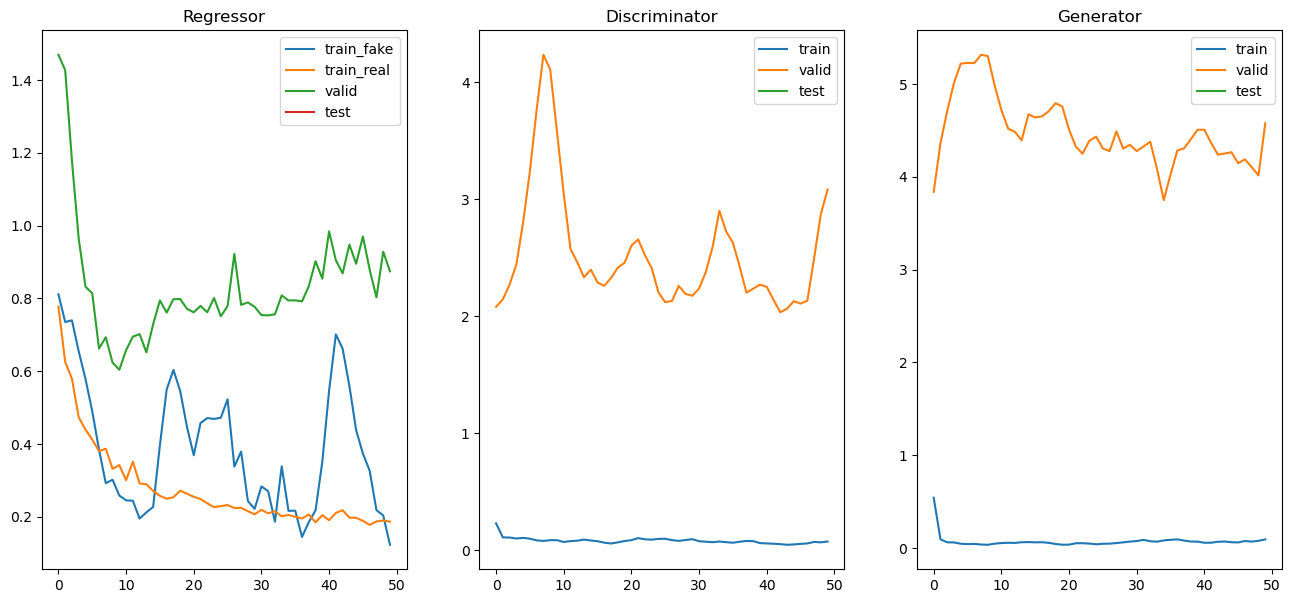

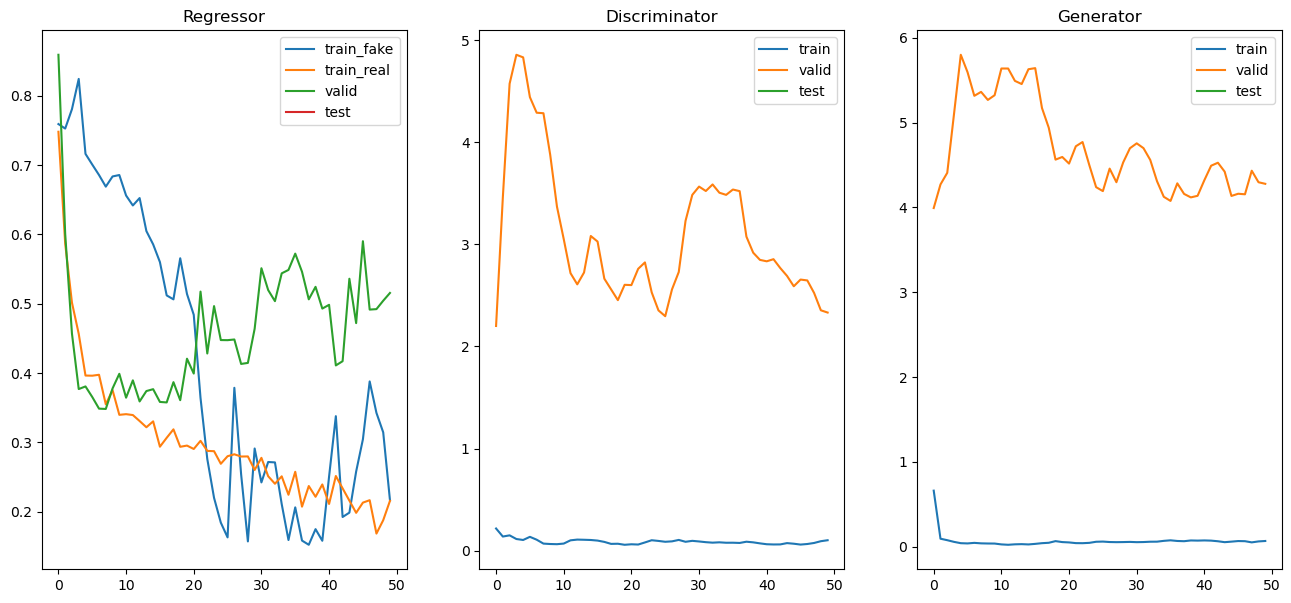

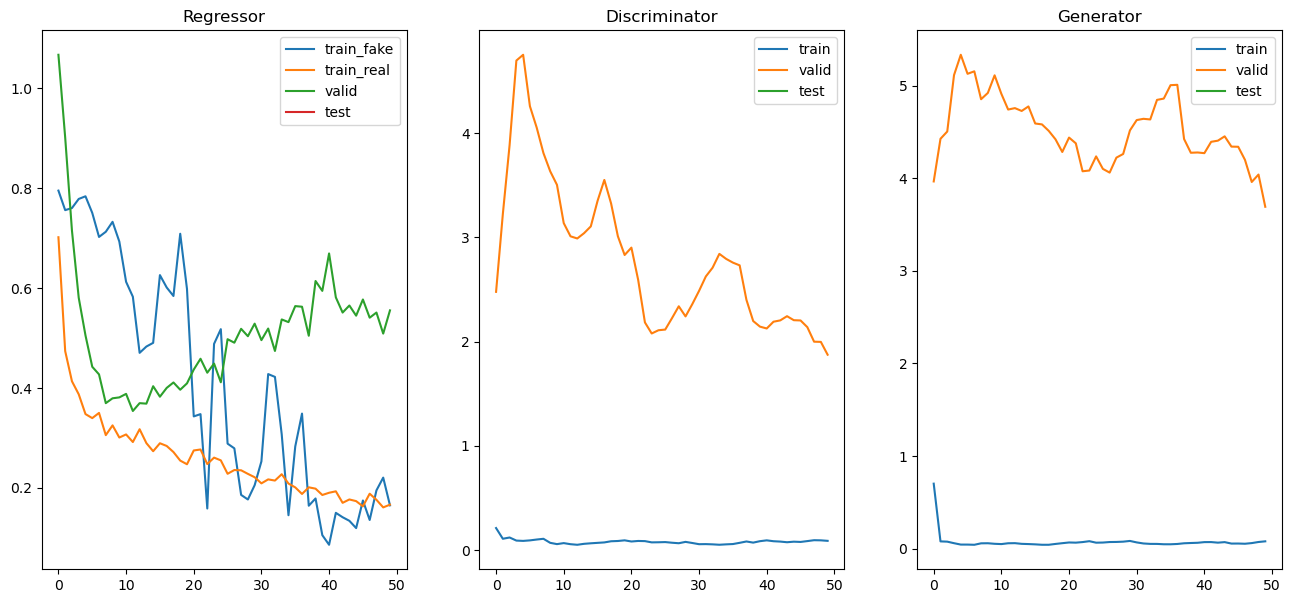

In [18]:
for i in range(len(losses1)):
    visualize_subplots(losses1[i], log=False, clip_first=0.0, dilation=0)

In [24]:
save_models(D=Ds, G=Gs, R=Rs, path="gan_results/models/{0}_W{1}".format(SOFT_SENSOR_INDEX, W))